<a href="https://colab.research.google.com/github/dominiquebuford/DL-individual/blob/main/DL_posefinetune_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch, detectron2

from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5a6x3kkb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5a6x3kkb
  Resolved https://github.com/facebookresearch/detectron2.git to commit cc9266c2396d5545315e3601027ba4bc28e8c95b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6147627 sha256=70855f48f4a022ffa176b1b3129843

In [2]:
!gcloud init
from google.colab import files

# Upload the JSON key file
uploaded = files.upload()
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/service-account-key.json'



Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

You must log in to continue. Would you like to log in (Y/n)?  y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%

Saving service-account-key.json to service-account-key.json


In [ ]:
#grab annotations from google cloud platform bucket
!gsutil cp gs://dl-individual-project/annotations/train_annotations.json /content/train_annotations.json
!gsutil cp gs://dl-individual-project/annotations/val_annotations.json /content/val_annotations.json

In [4]:
#grab images and place into local train and val folders
from google.cloud import storage
import pandas as pd
import os



bucket_name = 'dl-individual-project'
images_folder = 'trainImages/'
client = storage.Client()
bucket = client.get_bucket(bucket_name)
blobs_train = bucket.list_blobs(prefix = images_folder)
blob_names = [blob.name[len(images_folder):] for blob in blobs_train]

#need to create the val and train folders before calling the two loops
folder_paths = ["/content/val", "/content/train"]
for folder_path in folder_paths:
  # Create the folder
  os.makedirs(folder_path, exist_ok=True)

for name in blob_names:
    fullName = f"trainImages/{name}"
    tempName = f"train/{name}"
    blob = bucket.blob(fullName)
    blob.download_to_filename(tempName)

images_folder = 'valImages/'
blobs_val = bucket.list_blobs(prefix = images_folder)
blob_names_val = [blob.name[len(images_folder):] for blob in blobs_val]

for name in blob_names_val:
    fullName = f"valImages/{name}"
    tempName = f"val/{name}"
    blob = bucket.blob(fullName)
    blob.download_to_filename(tempName)

In [5]:
register_coco_instances("my_dataset_train", {}, "/content/train_annotations.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/val_annotations.json", "/content/val")

In [6]:
keypoint_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']
keypoint_flip_map = [
    ('a', 'f'),  # 'r ankle' and 'l ankle'
    ('b', 'e'),  # 'r knee' and 'l knee'
    ('c', 'd'),  # 'r hip' and 'l hip'
    ('j', 'i'),  # 'head top' and 'upper neck'
    ('k', 'h'),  # 'r wrist' and 'l wrist'
    ('l', 'g'),  # 'r elbow' and 'l elbow'
    ('m', 'p'),  # 'r shoulder' and 'l shoulder'
]
MetadataCatalog.get("my_dataset_train").thing_classes = ["person"]
MetadataCatalog.get("my_dataset_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("my_dataset_train").keypoint_names = keypoint_names
MetadataCatalog.get("my_dataset_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("my_dataset_train").evaluator_type="coco"

In [7]:
DatasetCatalog.get("my_dataset_train")

[03/20 16:52:49 d2.data.datasets.coco]: Loaded 674 images in COCO format from /content/train_annotations.json


[{'file_name': '/content/train/018247633.jpg',
  'height': 480,
  'width': 848,
  'image_id': 0,
  'annotations': [{'iscrowd': 0,
    'bbox': [275.0, 27.5112, 158.0, 438.4888],
    'keypoints': [275.5,
     454.5,
     1,
     294.5,
     362.5,
     1,
     337.5,
     264.5,
     1,
     395.5,
     285.5,
     1,
     402.5,
     389.5,
     1,
     429.5,
     466.5,
     1,
     366.5,
     275.5,
     1,
     377.5,
     116.5,
     1,
     374.5271,
     103.9888,
     1,
     356.4729,
     28.0112,
     1,
     290.5,
     233.5,
     1,
     317.5,
     183.5,
     1,
     336.5,
     110.5,
     1,
     418.5,
     121.5,
     1,
     433.5,
     225.5,
     1,
     377.5,
     290.5,
     1],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>}]},
 {'file_name': '/content/train/023320492.jpg',
  'height': 1080,
  'width': 1920,
  'image_id': 1,
  'annotations': [{'iscrowd': 0,
    'bbox': [553.0, 157.1402, 600.0, 741.8598],
    'keypoints': [553.5,
     818.5,
    

In [8]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

def custom_mapper(dataset_dict):
  image = utils.read_image(dataset_dict["file_name"], format="BGR")
  transform_list = [
      T.Resize((800,600)),
      T.RandomLighting(0.5),
      T.RandomContrast(0.3, 0.5),  # Adjust the contrast range for dim lighting
      T.RandomSaturation(0.1, 0.3),
      T.RandomBrightness(0.1, 0.2),
  ]
  image, transforms = T.apply_transform_gens(transform_list, image)
  dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

  annos = [
      utils.transform_instance_annotations(obj, transforms, image.shape[:2])
      for obj in dataset_dict.pop("annotations")
      if obj.get("iscrowd", 0) == 0
  ]
  instances = utils.annotations_to_instances(annos, image.shape[:2])
  dataset_dict["instances"] = utils.filter_empty_instances(instances)
  return dataset_dict

[03/20 16:52:50 d2.data.datasets.coco]: Loaded 674 images in COCO format from /content/train_annotations.json


/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


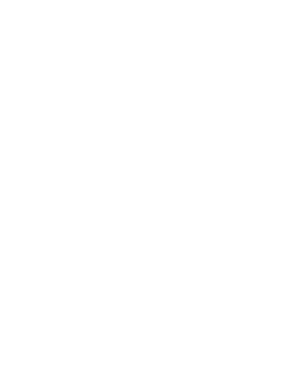

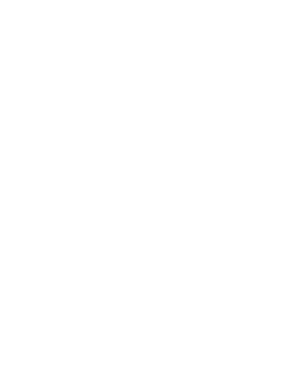

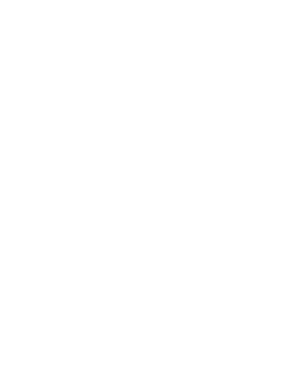

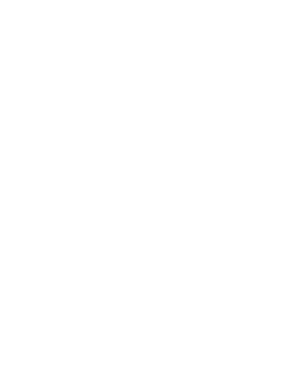

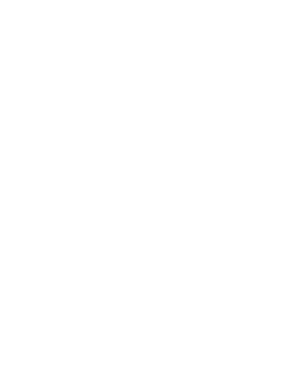

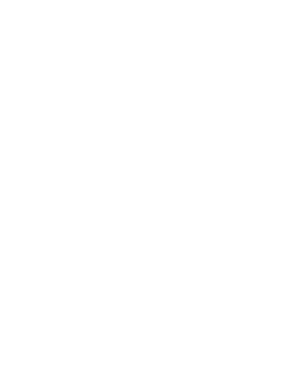

In [9]:
import random
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt


dataset_dicts = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

#import os

# Define a directory to save the augmented images
output_dir = "augmented_images"
os.makedirs(output_dir, exist_ok=True)

# Loop over your dataset and apply data augmentation
for idx, dataset_dict in enumerate(dataset_dicts):
    if idx >5:
      break
    # Apply your custom mapper function to augment the image
    augmented_dict = custom_mapper(dataset_dict)

    # Get the augmented image from the dataset dictionary
    augmented_image = augmented_dict["image"]

    # Convert the augmented image from tensor to numpy array
    augmented_image = augmented_image.permute(1, 2, 0).numpy()

    # Convert the augmented image from BGR to RGB (if necessary)
    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)

    # Save the augmented image to disk
    output_path = os.path.join(output_dir, f"augmented_image_{idx}.jpg")
    cv2.imwrite(output_path, augmented_image)

    # Display the augmented image
    cv2_imshow(augmented_image)
    cv2.waitKey(0)  # Wait for a key press to close the window

# Close all OpenCV windows
cv2.destroyAllWindows()

In [10]:
import numpy as np

In [14]:
cfg = get_cfg() # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.MAX_ITER = 800
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster (default: 512)
#cfg.SOLVER.STEPS = (200, 500)
cfg.SOLVER.GAMMA = 0.005
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((16, 1), dtype=float).tolist()

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # hand
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 16

In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_train_loader, build_detection_test_loader

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

  @classmethod
  def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

  @classmethod
  def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=custom_mapper)

In [15]:
import os
from detectron2.engine import DefaultTrainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/20 16:58:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.keypoint_head.score_lowres.{bias, weight}


[03/20 16:58:02 d2.engine.train_loop]: Starting training from iteration 0
[03/20 16:58:49 d2.utils.events]:  eta: 0:28:44  iter: 19  total_loss: 8.462  loss_cls: 0.1677  loss_box_reg: 0.1381  loss_keypoint: 8.08  loss_rpn_cls: 0.03246  loss_rpn_loc: 0.02703    time: 2.2780  last_time: 1.7579  data_time: 0.8798  last_data_time: 0.4940   lr: 0.00024726  max_mem: 6397M
[03/20 16:59:25 d2.utils.events]:  eta: 0:24:30  iter: 39  total_loss: 8.349  loss_cls: 0.1094  loss_box_reg: 0.1566  loss_keypoint: 8.009  loss_rpn_cls: 0.01783  loss_rpn_loc: 0.02669    time: 2.0364  last_time: 1.8008  data_time: 0.5169  last_data_time: 0.4974   lr: 0.00049701  max_mem: 6398M
[03/20 17:00:02 d2.utils.events]:  eta: 0:22:14  iter: 59  total_loss: 7.986  loss_cls: 0.08871  loss_box_reg: 0.1377  loss_keypoint: 7.722  loss_rpn_cls: 0.01343  loss_rpn_loc: 0.02048    time: 1.9621  last_time: 2.1677  data_time: 0.4982  last_data_time: 0.6423   lr: 0.00074676  max_mem: 6398M
[03/20 17:00:39 d2.utils.events]:  eta

In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader

# Build the test loader using your custom mapper
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
val_loader = trainer.build_test_loader(cfg, "my_dataset_val")
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
results = inference_on_dataset(trainer.model, val_loader, evaluator)
predictor = DefaultPredictor(cfg)

[03/20 17:23:51 d2.data.datasets.coco]: Loaded 169 images in COCO format from /content/val_annotations.json
[03/20 17:23:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/20 17:23:51 d2.data.common]: Serializing 169 elements to byte tensors and concatenating them all ...
[03/20 17:23:51 d2.data.common]: Serialized dataset takes 0.09 MiB
WARNING [03/20 17:23:51 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/20 17:23:51 d2.evaluation.evaluator]: Start inference on 169 batches
[03/20 17:23:54 d2.evaluation.evaluator]: Inference done 11/169. Dataloading: 0.0500 s/iter. Inference: 0.1509 s/iter. Eval: 0.0047 s/iter. Total: 0.2055 s/iter. ETA=0:00:32
[03/20 17:23:59 d2.evaluation.evaluator]: Inference done 31/169. Dataloading: 0.0600 s/iter. Inference: 0.1927 s/iter. Eval: 0.0026 s/iter. Total: 0.2562 s/iter. ETA=0:00:35
[03/20 17:2

In [ ]:
dataset_dicts = DatasetCatalog.get("my_dataset_val")


import os

# Define a directory to save the augmented images
output_dir = "augmented_images"
os.makedirs(output_dir, exist_ok=True)

# Loop over your dataset and apply data augmentation
for idx, dataset_dict in enumerate(dataset_dicts):
    # Apply your custom mapper function to augment the image
    augmented_dict = custom_mapper(dataset_dict)

    # Get the augmented image from the dataset dictionary
    augmented_image = augmented_dict["image"]
        # Convert the augmented image from tensor to numpy array
    augmented_image = augmented_image.permute(1, 2, 0).numpy()

    # Convert the augmented image from BGR to RGB (if necessary)
    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)

    # Save the augmented image to disk
    output_path = os.path.join(output_dir, f"augmented_image_{idx}.jpg")
    cv2.imwrite(output_path, augmented_image)

    finalImage = cv2.imread(output_path)

    predictions = predictor(finalImage)


    # Visualize the predictions on the augmented image
    v = Visualizer(finalImage[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(predictions["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.waitKey(0)


# Close all OpenCV windows
cv2.destroyAllWindows()


[03/20 17:24:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


-1

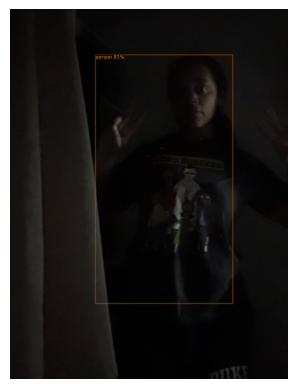

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
image = cv2.imread("output.jpg")
#image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Perform prediction
outputs = predictor(image)
visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

# Draw predictions on the image
vis_output = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(vis_output.get_image()[:, :, ::-1])
cv2.waitKey(0)
# Convert image back to BGR for visualization with OpenCV
#vis_image = vis_output.get_image()[:, :, ::-1]

In [ ]:
image = cv2.imread("output.jpg")
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
image_clahe = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
image_clahe[:, :, 0] = clahe.apply(image_clahe[:, :, 0])
image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_LAB2BGR)
outputs = predictor(image_clahe)
visualizer = Visualizer(image_clahe[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

# Draw predictions on the image
vis_output = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(vis_output.get_image()[:, :, ::-1])
cv2.waitKey(0)

In [18]:
instances = outputs["instances"]
# Get the index of the bounding box with the highest confidence score
highest_confidence_index = instances.scores.argmax()

# Retrieve the keypoints associated with the highest confidence bounding box
highest_confidence_keypoints = instances.pred_keypoints[highest_confidence_index].cpu().numpy()

highest_confidence_keypoints

array([[1.42512085e+03, 2.37587158e+03, 4.04496640e-02],
       [1.14723584e+03, 1.22987073e+03, 5.21636643e-02],
       [7.15935242e+02, 1.52505273e+03, 5.26858382e-02],
       [7.15935242e+02, 1.52505273e+03, 5.97713925e-02],
       [1.14144666e+03, 1.22987073e+03, 4.06045541e-02],
       [1.75510925e+03, 1.89837134e+03, 1.17786281e-01],
       [7.15935242e+02, 1.50190125e+03, 1.68107916e-02],
       [1.59011499e+03, 1.08227966e+03, 8.00235122e-02],
       [1.56695801e+03, 9.46264343e+02, 1.32328019e-01],
       [1.37012268e+03, 4.65870056e+02, 5.88040389e-02],
       [1.27459985e+03, 1.48743164e+03, 2.73002144e-02],
       [7.15935242e+02, 1.11990088e+03, 2.46432479e-02],
       [1.26591602e+03, 1.16331006e+03, 5.54460920e-02],
       [1.80431812e+03, 9.78097839e+02, 1.19830914e-01],
       [1.85063232e+03, 1.29932532e+03, 2.47359052e-02],
       [1.76668774e+03, 1.31379504e+03, 3.54886539e-02]], dtype=float32)